In [1]:
import numpy as np
import pandas as pd

import glob
import pickle
import os
import re
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
#!pip install lightgbm

In [3]:
data = pd.read_csv('df1.csv')
data

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,5,5,100008,0.0,0,0,0,0,99000.0,490495.5,...,27702.964286,969603.750,227.160,432218.295,27360.502714,957617.595,-82.0,-1237.800000,-43323.0,35.0
4,6,6,100009,0.0,1,1,0,1,171000.0,1560726.0,...,9568.531765,487995.120,6155.280,17341.605,9568.531765,487995.120,-58.0,-864.411765,-44085.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234761,307503,307503,456247,0.0,1,0,0,0,112500.0,345510.0,...,5685.241231,761822.325,43.830,90990.000,5685.241231,761822.325,-34.0,-1606.014925,-215206.0,134.0
234762,307505,307505,456249,0.0,1,0,0,0,112500.0,225000.0,...,22771.410000,273256.920,22770.405,22782.465,22771.410000,273256.920,-1168.0,-1332.500000,-15990.0,12.0
234763,307508,307508,456253,0.0,1,0,0,0,153000.0,677664.0,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0
234764,307509,307509,456254,1.0,1,0,0,0,171000.0,370107.0,...,10239.832895,194556.825,2296.440,19065.825,10239.832895,194556.825,-18.0,-161.263158,-3064.0,19.0


In [4]:
data.isna().mean()

Unnamed: 0                        0.0
index                             0.0
SK_ID_CURR                        0.0
TARGET                            0.0
CODE_GENDER                       0.0
                                 ... 
INSTAL_AMT_PAYMENT_SUM            0.0
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0.0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0.0
INSTAL_COUNT                      0.0
Length: 559, dtype: float64

In [5]:
check_for_nan = data.isnull().values.any()
print (check_for_nan)

True


In [6]:
total_nan_values = data.isnull().sum().sum()
print (total_nan_values)

14


In [7]:
data = data.dropna()

In [8]:
check_for_nan = data.isnull().values.any()
print (check_for_nan)

False


In [9]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [10]:
total_nan_values = data.isnull().sum().sum()
print (total_nan_values)

0


In [11]:
# checking for infinity
print()
print("checking for infinity")
  
ds = data.isin([np.inf, -np.inf])
print(ds)
  
# printing the count of infinity values
print()
print("printing the count of infinity values")
  
count = np.isinf(data).values.sum()
print("It contains " + str(count) + " infinite values")
  
# printing column name where infinity is present
print()
print("printing column name where infinity is present")
col_name = data.columns.to_series()[np.isinf(data).any()]
print(col_name)
  
# printing row index with infinity
print()
print("printing row index with infinity ")
  
r = data.index[np.isinf(data).any(1)]
print(r)


checking for infinity
        Unnamed: 0  index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  \
0            False  False       False   False        False         False   
1            False  False       False   False        False         False   
2            False  False       False   False        False         False   
3            False  False       False   False        False         False   
4            False  False       False   False        False         False   
...            ...    ...         ...     ...          ...           ...   
234761       False  False       False   False        False         False   
234762       False  False       False   False        False         False   
234763       False  False       False   False        False         False   
234764       False  False       False   False        False         False   
234765       False  False       False   False        False         False   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CRE

In [12]:
# Replace infinite updated data with nan
data.drop(index=153488, inplace=True)


C:\Users\kbouh\AppData\Local\Temp\ipykernel_24656\3155487320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(index=153488, inplace=True)


In [13]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [14]:
#Séparation jeu de données en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
                        train_test_split(X, 
                                         y,  
                                         test_size = 0.2, 
                                         random_state = 42
                                        )

In [15]:
#Prétraitement des données avec StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
#On veut que les faux négatifs pèsent 10 x plus que les faux positifs

In [29]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score

In [30]:
f_scorer = make_scorer(fbeta_score, beta=0.1)

In [31]:
from sklearn.linear_model import LogisticRegression

In [57]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


    features = []
    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[:,-1]
        for i in range(20):
            features.append(X_train_scaled[indices[i]]) #After RFECV selection > X_data created

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

        show()

In [58]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve


In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
%%time
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,scoring=f_scorer,cv=5)
logreg_cv.fit(X_train_scaled,y_train)
#lr = LogisticRegression(C = 0.0001, max_iter=100)
#lr.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_test, logreg_cv.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, logreg_cv.predict(X_test_scaled)))

C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC : 0.7672
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     43217
         1.0       0.51      0.03      0.05      3735

    accuracy                           0.92     46952
   macro avg       0.72      0.51      0.50     46952
weighted avg       0.89      0.92      0.89     46952

CPU times: total: 17min 56s
Wall time: 4min 44s


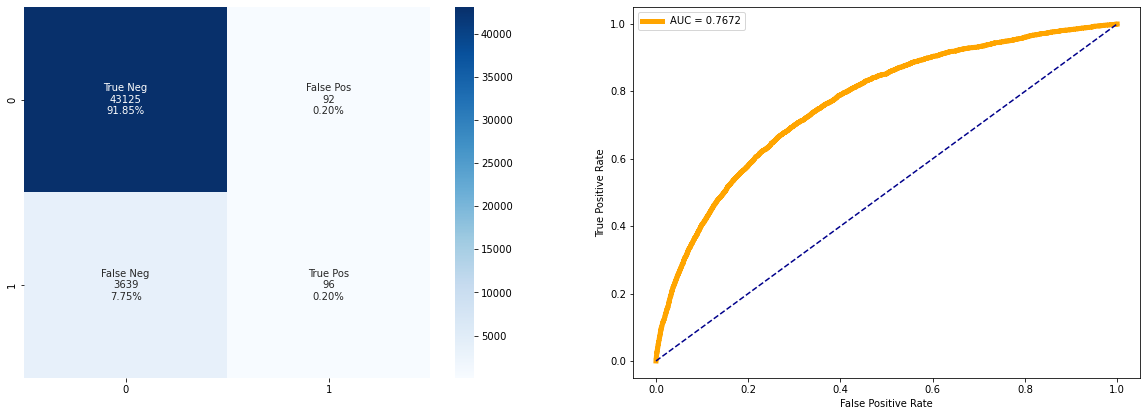

In [64]:
cf_matrix_roc_auc(logreg_cv, y_test, logreg_cv.predict(X_test_scaled), logreg_cv.predict_proba(X_test_scaled)[:,1], feature_importances=None)

In [66]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [67]:
%%time
grid = {
    'n_estimators' : [20, 50], #nombre d'arbres de décision
    #'min_samples_leaf' : [5,10,15], #nombre de feuilles minimales dans un noeud
    #'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}
rfc=RandomForestClassifier(class_weight='balanced')
rfc_cv=GridSearchCV(rfc,grid,scoring=f_scorer,cv=5)
rfc_cv.fit(X_train_scaled,y_train)
#lr = LogisticRegression(C = 0.0001, max_iter=100)
#lr.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_test, rfc_cv.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rfc_cv.predict(X_test_scaled)))

AUC : 0.6602
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     43217
         1.0       0.26      0.00      0.00      3735

    accuracy                           0.92     46952
   macro avg       0.59      0.50      0.48     46952
weighted avg       0.87      0.92      0.88     46952

CPU times: total: 7min 36s
Wall time: 7min 36s


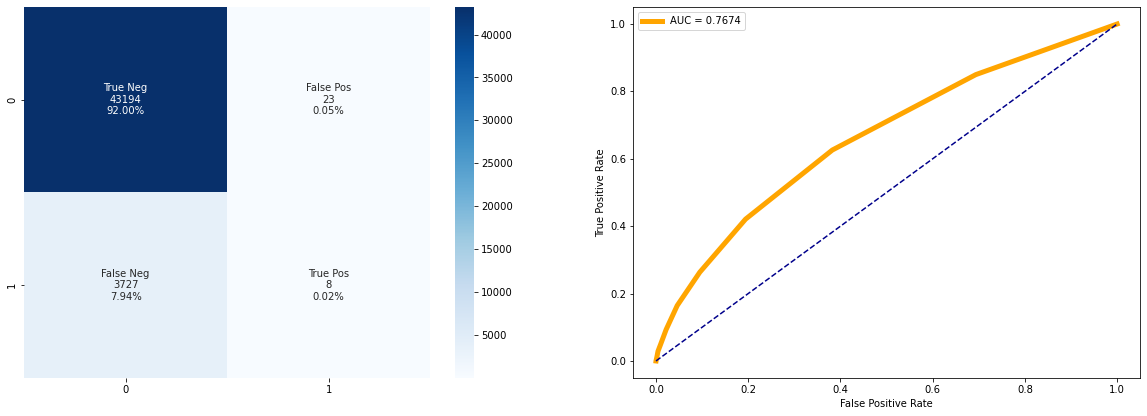

In [100]:
cf_matrix_roc_auc(rfc_cv, y_test, rfc_cv.predict(X_test_scaled), rfc_cv.predict_proba(X_test_scaled)[:,1], feature_importances=None)

In [ ]:
#Gradient Boosting

In [79]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          LGBMClassifier(),
          XGBClassifier()]

In [80]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [95]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [96]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
base_models.sort_values('AUC', ascending=False, inplace=True)


CPU times: total: 23min 16s
Wall time: 3min 5s


In [97]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.773438,0.920941,0.549356,0.03427,0.064516,16.87266
1,XGBClassifier,0.76444,0.919066,0.43299,0.056225,0.099526,168.268663


In [ ]:
#LGBM sera sélectionné

In [98]:
%%time
grid = {
    'n_estimators' : [20, 50], #nombre d'arbres de décision
    #'min_samples_leaf' : [5,10,15], #nombre de feuilles minimales dans un noeud
    #'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}
lgbm=LGBMClassifier()
lgbm_cv=GridSearchCV(lgbm,grid,scoring=f_scorer,cv=5)
lgbm_cv.fit(X_train_scaled,y_train)
#lr = LogisticRegression(C = 0.0001, max_iter=100)
#lr.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_test, lgbm_cv.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_cv.predict(X_test_scaled)))

AUC : 0.7674
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     43217
         1.0       0.52      0.02      0.03      3735

    accuracy                           0.92     46952
   macro avg       0.72      0.51      0.50     46952
weighted avg       0.89      0.92      0.88     46952

CPU times: total: 13min 21s
Wall time: 7min 44s


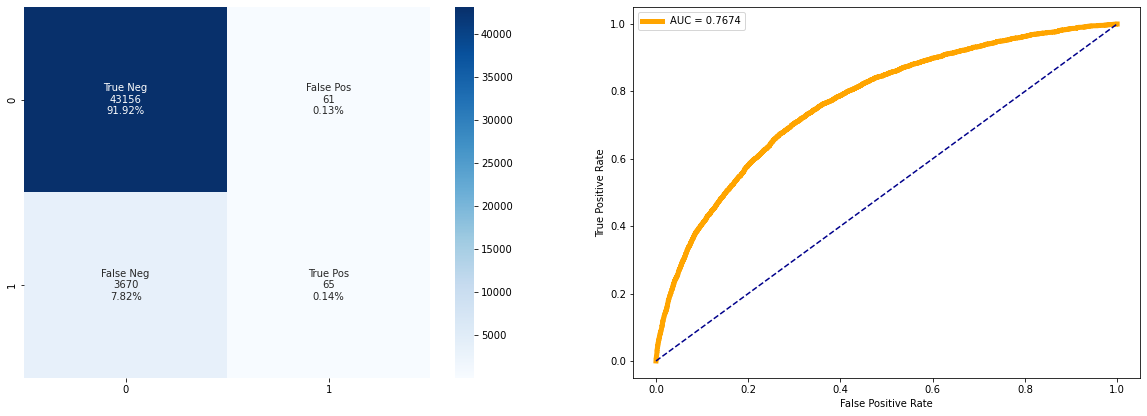

In [101]:
cf_matrix_roc_auc(lgbm_cv, y_test, lgbm_cv.predict(X_test_scaled), lgbm_cv.predict_proba(X_test_scaled)[:,1], feature_importances=None)

In [105]:
#Feature Selection

In [107]:
from sklearn.feature_selection import RFECV

In [108]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 558 features.
Fitting estimator with 553 features.
Fitting estimator with 548 features.
Fitting estimator with 543 features.
Fitting estimator with 538 features.
Fitting estimator with 533 features.
Fitting estimator with 528 features.
Fitting estimator with 523 features.
Fitting estimator with 518 features.
Fitting estimator with 513 features.
Fitting estimator with 508 features.
Fitting estimator with 503 features.
Fitting estimator with 498 features.
Fitting estimator with 493 features.
Fitting estimator with 488 features.
Fitting estimator with 483 features.
Fitting estimator with 478 features.
Fitting estimator with 473 features.
Fitting estimator with 468 features.
Fitting estimator with 463 features.
Fitting estimator with 458 features.
Fitting estimator with 453 features.
Fitting estimator with 448 features.
Fitting estimator with 443 features.
Fitting estimator with 438 features.
Fitting estimator with 433 features.
Fitting estimator with 428 features.
F

In [ ]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(), 
              step=10, 
              cv=5, 
              scoring='accuracy', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

In [109]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 223
Selected Features: [ True False False  True  True False False  True  True  True  True  True
  True  True  True  True False False  True False]
Feature Ranking : [ 1 26 26  1  1 26  8  1  1  1  1  1  1  1  1  1 28 28  1 28]


In [112]:
ranking = pd.DataFrame({'Features': X_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

223
['Unnamed0', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MIN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM', 'CLOSED_AMT_CREDIT_SUM_DEBT_MAX', 'CLOSED_AMT_CREDIT_SUM_SUM', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'PREV_AMT_APPLICATION_MEAN', 'CLOSED_AMT_CREDIT_SUM_MAX', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'CLOSED_DAYS_CREDIT_ENDDATE_MIN', 'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_MAX', 'CLOSED_DAYS_CREDIT_MIN', 'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'PREV_AMT_CREDIT_MIN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN', 'PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN', 'PREV_NAME_CONTRACT_TYPE_Consumerloans_MEAN', 'PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_CNT_PAYMENT_MEAN', 'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MIN', 'PREV_HOUR_APPR_PROCESS_START_MEAN',

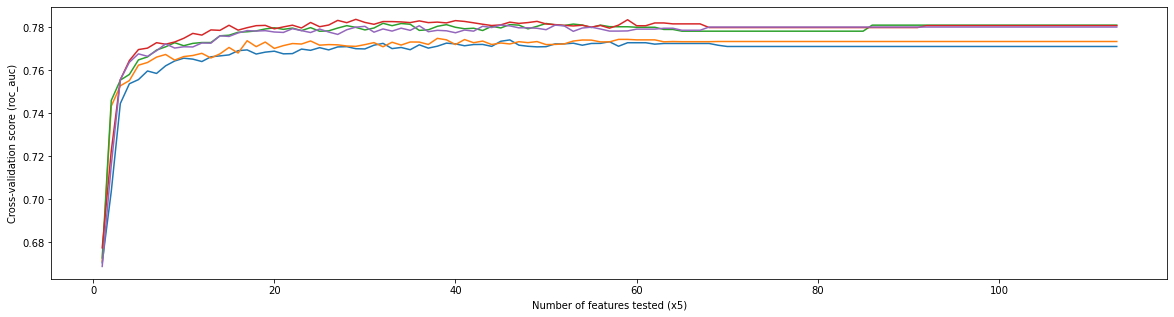

In [114]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

In [135]:
rfecv.grid_scores_[10]

array([0.76523982, 0.76692684, 0.77256931, 0.77721329, 0.77091169])

In [136]:
rfecv.grid_scores_[20]

array([0.7677054 , 0.77152793, 0.77910051, 0.78023179, 0.77766246])

In [127]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_cv.best_estimator_.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train.columns[index], lgbm_cv.best_estimator_.feature_importances_[index]]) 

['EXT_SOURCE_2', 78]
['PAYMENT_RATE', 67]
['EXT_SOURCE_3', 66]
['EXT_SOURCE_1', 60]
['DAYS_BIRTH', 42]
['INSTAL_DPD_MEAN', 33]
['PREV_CNT_PAYMENT_MEAN', 32]
['AMT_ANNUITY', 32]
['ANNUITY_INCOME_PERC', 27]
['APPROVED_CNT_PAYMENT_MEAN', 24]
['CODE_GENDER', 22]
['ACTIVE_DAYS_CREDIT_MAX', 21]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 21]
['BURO_DAYS_CREDIT_MAX', 20]
['BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 20]
['BURO_AMT_CREDIT_SUM_DEBT_MEAN', 19]
['PREV_APP_CREDIT_PERC_MIN', 18]
['BURO_DAYS_CREDIT_MEAN', 17]
['INSTAL_AMT_PAYMENT_MIN', 16]
['DAYS_ID_PUBLISH', 15]
['AMT_CREDIT', 15]
['DAYS_EMPLOYED', 15]
['POS_MONTHS_BALANCE_SIZE', 14]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 14]
['INSTAL_DAYS_ENTRY_PAYMENT_SUM', 14]
['DAYS_EMPLOYED_PERC', 14]
['NAME_EDUCATION_TYPE_Highereducation', 14]
['ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 13]
['INSTAL_AMT_PAYMENT_SUM', 13]
['AMT_GOODS_PRICE', 13]
['INSTAL_DAYS_ENTRY_PAYMENT_MAX', 13]
['BURO_CREDIT_TYPE_Microloan_MEAN', 13]
['POS_SK_DPD_DEF_MEAN', 13]
['ACTIVE_AMT_CREDIT_SUM_

In [123]:
coefficients = abs(lgbm_cv.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

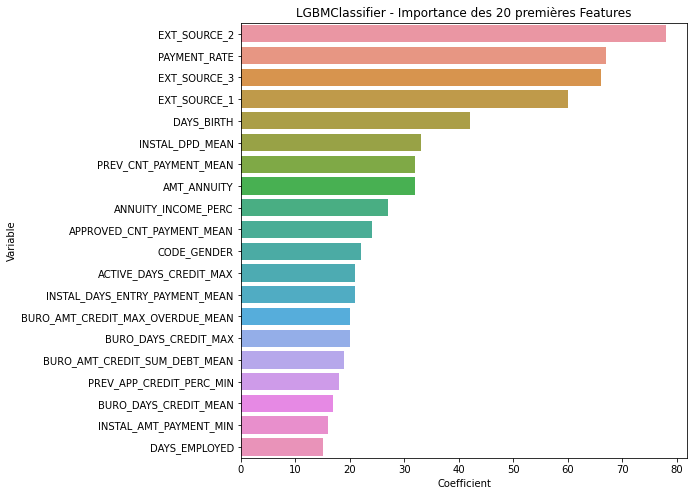

In [125]:
plt.figure(figsize=(8,8))
plt.title('LGBMClassifier - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [139]:
data1 = data[['EXT_SOURCE_2','PAYMENT_RATE','EXT_SOURCE_3','DAYS_BIRTH','INSTAL_DPD_MEAN','PREV_CNT_PAYMENT_MEAN','AMT_ANNUITY','ANNUITY_INCOME_PERC','APPROVED_CNT_PAYMENT_MEAN','TARGET']]

In [140]:
data1

,EXT_SOURCE_2,PAYMENT_RATE,EXT_SOURCE_3,DAYS_BIRTH,INSTAL_DPD_MEAN,PREV_CNT_PAYMENT_MEAN,AMT_ANNUITY,ANNUITY_INCOME_PERC,APPROVED_CNT_PAYMENT_MEAN,TARGET
0,0.262949,0.060749,0.139376,-9461,0.000000,24.00,24700.5,0.121978,24.00,1.0
1,0.622246,0.027598,0.466757,-16765,0.000000,10.00,35698.5,0.132217,10.00,0.0
2,0.555912,0.050000,0.729567,-19046,0.000000,4.00,6750.0,0.100000,4.00,0.0
3,0.354225,0.056101,0.621226,-16941,37.628571,14.00,27517.5,0.277955,14.00,0.0
4,0.724000,0.026463,0.492060,-13778,0.137255,8.00,41301.0,0.241526,8.00,0.0
...,...,...,...,...,...,...,...,...,...,...
234761,0.501221,0.051433,0.609276,-11870,0.238806,7.75,17770.5,0.157960,7.75,0.0
234762,0.346391,0.098000,0.742182,-24384,0.000000,12.00,22050.0,0.196000,12.00,0.0
234763,0.535722,0.044239,0.218859,-14966,0.642857,5.00,29979.0,0.195941,5.00,0.0
234764,0.514163,0.054592,0.661024,-11961,0.000000,15.00,20205.0,0.118158,15.00,1.0


In [141]:
X1 = data1.drop('TARGET', axis=1)
y1 = data['TARGET']

In [142]:
X1_train, X1_test, y1_train, y1_test = \
                        train_test_split(X1, 
                                         y1,  
                                         test_size = 0.2, 
                                         random_state = 42
                                        )

In [143]:
#Prétraitement des données avec StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

In [144]:
%%time
grid = {
    'n_estimators' : [20, 50], #nombre d'arbres de décision
    #'min_samples_leaf' : [5,10,15], #nombre de feuilles minimales dans un noeud
    #'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}
lgbm=LGBMClassifier()
lgbm_cv=GridSearchCV(lgbm,grid,scoring=f_scorer,cv=5)
lgbm_cv.fit(X1_train_scaled,y1_train)
#lr = LogisticRegression(C = 0.0001, max_iter=100)
#lr.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y1_test, lgbm_cv.predict_proba(X1_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y1_test, lgbm_cv.predict(X1_test_scaled)))

AUC : 0.7482
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     43217
         1.0       0.57      0.01      0.02      3735

    accuracy                           0.92     46952
   macro avg       0.75      0.50      0.49     46952
weighted avg       0.89      0.92      0.88     46952

CPU times: total: 29.6 s
Wall time: 3.94 s


In [145]:
data_reduced = data1.to_csv('data1', index=True)
print('\nCSV String:\n', data_reduced)


CSV String:
 None


In [ ]:
#Pipeline de prédiction

In [ ]:
#from sklearn.ensemble import GradientBoostingRegressor

In [150]:
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor

In [170]:
classifier = ensemble.HistGradientBoostingClassifier()
params = {'learning_rate': [1e-1, 2e-1, 3e-1],
          'max_depth': [2, 4, 5],
          'min_samples_leaf': [30, 31, 32],
          'max_iter': [100, 150]
          }
gsv = model_selection.GridSearchCV(classifier, params, cv=5)
gsv.fit(X1_train_scaled, y1_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 5], 'max_iter': [100, 150],
                         'min_samples_leaf': [30, 31, 32]})

In [171]:
gsv.best_score_, gsv.best_params_

(0.9226063074913006,
 {'learning_rate': 0.2,
  'max_depth': 2,
  'max_iter': 100,
  'min_samples_leaf': 31})

In [172]:
gsv.best_estimator_.score(X1_test_scaled, y1_test)

0.9203228829442835

In [173]:
pipeline1 = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('classifier', ensemble.HistGradientBoostingClassifier(**gsv.best_params_))])

In [174]:
pipeline1.fit(X1_train, y1_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 HistGradientBoostingClassifier(learning_rate=0.2, max_depth=2,
                                                min_samples_leaf=31))])

In [175]:
pipeline1.score(X1_test_scaled, y1_test)

C:\Users\kbouh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0.9199395126938149

In [176]:
import joblib

In [177]:
joblib.dump(pipeline1, 'pipeline1_loan.joblib')

['pipeline1_loan.joblib']

In [178]:
#pip install mlflow --user

In [179]:
from mlflow.models.signature import infer_signature

In [180]:
signature = infer_signature(X1_train_scaled, y1_train)

In [181]:
import mlflow

In [182]:
mlflow.sklearn.save_model(pipeline1, 'mlflow_model_1', signature=signature)

C:\Users\kbouh\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
